<a href="https://colab.research.google.com/github/msdkhairi/svm/blob/master/svm_IPmethods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook **Interior Point Methods** are used to solve SVM. Two methods are implemented:

*   Barrier method
*   PDIP (Primal-Dual Interior Point method)

For more information about these methods, you can refer to chapter 11 of Convex Optimization book by Stephen Boyd.



In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# load data
data = np.loadtxt('data.txt', delimiter=' ')
X = data[:,:2]
y = data[:,2]

# Barrier method


### RBF kernel

In [0]:
# define functions to compute RBF kernel of data

def rbf(x1, x2, gamma=500):
  axis = None if x2.ndim==1 else 1
  return np.exp(-gamma*np.linalg.norm(x1-x2, axis=axis)**2)


def RBF_kernel(X, y):
    
  x_size = X.shape[0]
  K = np.zeros((x_size, x_size))

  for i in range(x_size):
    for j in range(x_size):
      K[i, j] = y[i] * y[j] * rbf(X[i], X[j])
  return K

def log(w):
  """ return the log(w) if w > 0 
      when w <= a very big negative number is returned
  """
  w = (w > 0) * w + (w <= 0) * 1e-300
  return np.log(w)


In [0]:
# compute RBF kernel
K_hat= RBF_kernel(X, y)

### Barrier Objective 

In [0]:
class Objective:
    def __init__(self, w_0, t=10**4, K=K_hat, C=0.1):
        self.w = w_0
        self.t = t
        self._K = K
        self._C = C
        
        self._ones = np.ones_like(w_0)
        self._update()
    
    def _update(self):
        self.f = self._f(self.w)
        self.grad = self.gradient(self.w)
        self.hess = self.hessian(self.w)
    
    def _f(self, w):
        f_hat = 0.5 * w.T @ self._K @ w - np.sum(w)
        g = -np.sum(log(w)) - np.sum(log(self._C*self._ones - w))
        return self.t*f_hat + g
    
    def gradient(self, w):
        return self.t * self._K @ w - self.t * self._ones - (
            np.divide(self._ones, w) + np.divide(self._ones, (w-self._C*self._ones)))
    
    def hessian(self, w):
        return self.t * self._K + np.diag(np.divide(self._ones, w**2)) + (
            np.diag(np.divide(self._ones, (w-self._C*self._ones)**2)))
        
    def setw(self, w):
        self.w = w
        self._update()
        
    def sett(self, t):
        self.t = t
        self._update()
        
    def __call__(self, w):
        return self._f(w)

### Newton's method

In [0]:
class Newton:
    
    def __init__(self, objective, A=y.reshape(-1, 1).T, eps=1e-16 ,alpha=0.01, beta=0.5):
        
        self.f = objective
        self._A = A
        self._epsilon = eps
        
        # params of backtracking line search
        self._alpha = alpha
        self._beta = beta
        
        self.dw = self._newton_step()
        self.decrement = self._newton_decrement()
    
    def _newton_step(self):
        # solving the KKT system to obtain newton step
        
        m = np.vstack((self.f.hess, self._A))
        m = np.hstack((m, np.vstack((self._A.T, 0))))
        
        b = np.hstack((-self.f.grad, 0))
        
        dw_nu = np.linalg.inv(m) @ b
        dw = dw_nu[:-1]
        return dw
    
    def _newton_decrement(self):
        # newton decrement ** 2
        return self.dw.T @ self.f.hess @ self.dw
    
    def _line_search(self):
        # back_tracking line search
        t = 1
        while self.f(self.f.w+t*self.dw) > self.f.f + (
            self._alpha * t * self.f.grad.T @ self.dw):
            t = self._beta * t
        return t
        
    def run(self):
        while self.decrement/2 > self._epsilon:
            t = self._line_search()
            self.f.setw(self.f.w + t*self.dw)            
            self.dw = self._newton_step()
            self.decrement = self._newton_decrement()
        return self.f.w
            
    def setobj(self, obj):
        self.objective = obj

### Barrier method

In [0]:
class Barrier:
    def __init__(self, objective, newton, t=10000, m=y.shape[0]*2, mu=4, eps=1e-8):
        self.f = objective
        self.newton = newton
        self.t = t
        self._m = m
        self._mu = mu
        self._eps = eps
        
        self.obj_values = []
        
    def update(self, w):
        # update w, t, and f
        self.f.setw(w)
        self.f.sett(self.t)
        self.newton.setobj(self.f)
                
    def report(self, plot=False):
        print('Iter {}: f* = {}'.format(self.iteration+1, self.f.f))
        
    def run(self):
        self.iteration = 0
        while self._m/self.t > self._eps:
            self.report()
            self.obj_values.append(self.f.f)
            
            w_star = self.newton.run()
            self.t = self._mu * self.t
            self.update(w_star)
            
            self.iteration += 1
            

### SVM

In [0]:
class SVMClassifier:
    def __init__(self, w, K, X, y):
        self.w = w
        self.K = K
        self.X = X
        self.y = y
        
        self.b = self._beta_0()
        
    def _beta_0(self):
        sup_vec = np.where(self.w > 1e-5)[0]
        b = 0
        for j in sup_vec:
            b += self.y[j] - np.sum(self.w*self.y*self.K[:,j])
        return b / sup_vec.size
    
    def predict(self, x):
        size = x.shape[0]
        y_pred = np.zeros(size)
        if x.ndim==1:
            return np.sign(np.sum(self.w*self.y*rbf(x, self.X)) + self.b)
        else:
            for i in range(size):
                y_pred[i] = self.predict(x[i])
            return y_pred
        
    def accuracy(self, x, y_true):
        y_pred = self.predict(x)
        return np.sum(y_pred==y_true) / y_true.size

### RUN the optimiztion

In [0]:
# define initial point w_0
w_0 = (y==-1) * np.count_nonzero(y==1) + (y==1) * np.count_nonzero(y==-1)
w_0 = w_0 / 10000
np.dot(w_0, y)

-9.33975119465913e-15

In [0]:
objective = Objective(w_0, t=10**4)
newton = Newton(objective, eps=1e-5)
barr = Barrier(objective, newton)

In [0]:
barr.run()

Iter 1: f* = -276649.1034325002
Iter 2: f* = -362773805.3551815
Iter 3: f* = -1452847330.3718767
Iter 4: f* = -5813141430.438658
Iter 5: f* = -23254317830.70578
Iter 6: f* = -93019023431.77428
Iter 7: f* = -372077845836.0482
Iter 8: f* = -1488313135453.144
Iter 9: f* = -5953254293921.527
Iter 10: f* = -23813018927795.062
Iter 11: f* = -95252077463289.2
Iter 12: f* = -381008311605265.75
Iter 13: f* = -1524033248173172.0


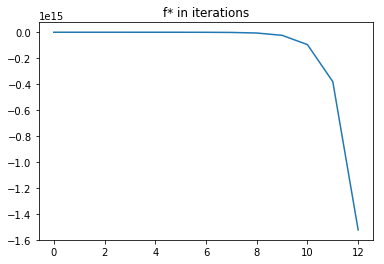

In [0]:
plt.figure(), plt.title('f* in iterations')
plt.plot(barr.obj_values);

In [0]:
barr_svm = SVMClassifier(barr.f.w, K_hat, X, y)
print('Accuracy of SVM using Barrier method=', barr_svm.accuracy(X, y))

Accuracy of SVM using Barrier method= 0.5561993047508691


# PDIP (Primal - Dual Interior Point method)

In [0]:
class PDIP:
  
  def __init__(self, w_0, u_0, v_0, landa_0, 
               Y=y, K=K_hat, C=0.1, mu=1000, m=y.shape[0]*2, t_0=1, 
               alpha=0.01, beta=0.5, eps_feas=1e-6, eps=2e-6):
    
    self.w = w_0
    self.u = u_0
    self.v = v_0
    self.landa = landa_0
    self.z = np.hstack((self.w, self.u, self.v, self.landa))
    self.dz = self.z.copy()
    
    
    self.y = Y
    self.K = K
    self.C = C
    self.mu = mu
    self.m = m
    self.t = t_0

    self.alpha = alpha
    self.beta = beta
    self.eps = eps
    self.eps_feas = eps_feas
    
    self.s = 0
    
    self.iteration = 0
    self.all_obj = []
    
    self.update()
  
  def update(self):

    self.eta = self._duality_gap()

    self.r_dual, self.r_cent, self.r_prim = self.r(self.z)
    
    self.z = self.z + self.s*self.dz
    
    self.w, self.u, self.v, self.landa = self.unpack(self.z)
    self.dw, self.du, self.dv, self.dlanda = self.unpack(self.dz)
    
    self.iteration += 1
    
    self.obj = self.objective()
    self.all_obj.append(self.obj)
    
  def _duality_gap(self):
    return np.dot(self.w, self.u) + np.dot((self.C - self.w), self.v)
  
  def unpack(self, z):
    s = self.w.shape[0] # size
    w = z[:s]
    u = z[s:2*s]
    v = z[2*s:3*s]
    landa = z[-1]
    return w, u, v, landa
  
  def r(self, z):
    w, u, v, landa = self.unpack(z) 
    r_dual = self.K @ w -1 - u + v + self.y*landa
    r_cent = np.diag(np.hstack((u, v))) @ np.hstack(
        (w, (self.C - w))) - 1/self.t
    r_prim = np.dot(self.y, w)
    return r_dual, r_cent, r_prim
  
  def r2(self, z):
    return(np.linalg.norm(np.hstack(self.r(z))))
      
  def pd_direction(self):
    y = self.y.reshape(-1, 1)
    n = self.w.shape[0]
    I = np.eye(n)
    Z = np.zeros((n, n))
    z = np.zeros((n, 1))
    
    drz = np.block([[self.K, -I, I, y], 
                    [np.diag(self.u), np.diag(self.w), Z, z],
                    [-np.diag(self.v), Z, np.diag(self.C - self.w), z],
                    [y.T, z.T, z.T, 0]])
    
    rz = np.hstack((self.r_dual, self.r_cent, self.r_prim))
    
    
    self.dz = -np.linalg.inv(drz) @ rz
  
  def _s_max(self):    
    L = np.hstack((self.u, self.v))
    dL = np.hstack((self.du, self.dv))
    Ls = [-L[i] / dL[i] for i in range(self.m) if dL[i] < 0]
    if not Ls:
      return 1
    return np.minimum(1, min(Ls))
  
  def line_search(self):
    s_max = self._s_max()
    self.s = 0.99 * s_max
    
    while (self.r2(self.z+self.dz) > 
        (1 - self.alpha*self.s) * self.r2(self.z)):
      self.s = self.s * self.beta

  
  def objective(self):
    return 0.5 * self.w.T @ self.K @ self.w - np.sum(self.w)
    
  def report(self):
    print('Iter {}: f*={}'.format(self.iteration, self.obj))
  
  def run(self):
    while True:
      self.t = self.mu * self.m / self.eta
      self.pd_direction()
      self.line_search()
      self.update()
      self.report()
    
      if (np.sqrt(np.linalg.norm(self.r_prim)**2 + 
                  np.linalg.norm(self.r_dual)**2) <= self.eps_feas 
          and self.eta <= self.eps):
        break
        

### Run PDIP

In [0]:
# PDIP initialization params
w_0 = (y==-1) * np.count_nonzero(y==1) + (y==1) * np.count_nonzero(y==-1)
w_0 = w_0 / 10000
# w_0, u_0, v_0 are all strictly feasible
u_0 = np.random.rand(w_0.shape[0])
v_0 = np.random.rand(w_0.shape[0])
landa_0 = 1

In [0]:
pdip = PDIP(w_0, u_0, v_0, landa_0)
pdip.run()

Iter 1: f*=-37.755232350470536
Iter 2: f*=-37.88678259812138
Iter 3: f*=-37.94213445448706
Iter 4: f*=-37.9978006201082
Iter 5: f*=-38.062201236826695
Iter 6: f*=-38.13625441300278
Iter 7: f*=-38.21997794948979
Iter 8: f*=-38.313220170589084
Iter 9: f*=-38.415713859714046
Iter 10: f*=-38.52705888695394
Iter 11: f*=-38.64670519541937
Iter 12: f*=-38.77394521413474
Iter 13: f*=-38.907917408451326
Iter 14: f*=-39.04762128908448
Iter 15: f*=-39.19194308092098
Iter 16: f*=-39.339689981850626
Iter 17: f*=-39.48962980786405
Iter 18: f*=-39.64053217296838
Iter 19: f*=-39.79120738408049
Iter 20: f*=-39.9405398747745
Iter 21: f*=-40.08751394071307
Iter 22: f*=-40.231230198571765
Iter 23: f*=-40.37090999885564
Iter 24: f*=-40.505871064751005
Iter 25: f*=-40.635138775332436
Iter 26: f*=-40.76011587100263
Iter 27: f*=-40.87950157216804
Iter 28: f*=-40.99153195587384
Iter 29: f*=-41.0986636629861
Iter 30: f*=-41.19929555091228
Iter 31: f*=-41.29420300850996
Iter 32: f*=-41.38466410973582
Iter 33: f*

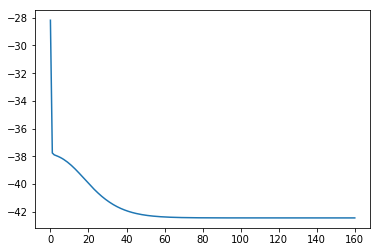

In [0]:
plt.plot(pdip.all_obj);

In [0]:
pdip_svm = SVMClassifier(pdip.w, K_hat, X, y)
print('Accuracy of SVM using PDIP=', pdip_svm.accuracy(X, y))

Accuracy of SVM using PDIP= 0.996523754345307
